In [1]:
## imports
from qiskit import *
from qiskit.algorithms import *
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit import quantum_info, IBMQ, Aer
from qiskit import BasicAer
from qiskit.utils import QuantumInstance
# backend = BasicAer.get_backend("statevector_simulator")
# quantum_instance = QuantumInstance(backend)
from qiskit.algorithms import AmplitudeEstimation
#from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
from qiskit.visualization import plot_histogram, plot_state_qsphere, plot_bloch_multivector, plot_bloch_vector
import numpy as np
from numpy import pi
import seaborn as sns
from IPython.display import Image
import matplotlib.pyplot as plt


In [2]:
# setup simulator using IBM_id
# IBMQ.save_account("1c62e8a0d2b058d0e797db9c811bc34582df5553e25812301cd1518662c0ab68d2378ac6c197b65f8be944d04b7e7439f034e3926a44fa8088538b3d13782c1a", overwrite= True)
provider = IBMQ.load_account()
IBMQ.get_provider(hub='ibm-q-education', group='iit-madras-1', project='quantum-computin')
# setup required backends 
lima = provider.get_backend('ibmq_lima')
manila = provider.get_backend('ibmq_manila')
qsm_simulator = Aer.get_backend('qasm_simulator')
stv_simulator = Aer.get_backend('statevector_simulator')
aer = Aer.get_backend('aer_simulator')


## Grover Search and Quantum Amplitude Estimation 

Here we will illustrate some of the nice application of Grover's search algorithm into pattern matching and Quantum Amplitude Estimation. We assume that the reader is familiar with some basic understanding of Grover's algorithm, a nice and detailed introduction can be found here https://qiskit.org/textbook/ch-algorithms/grover.html. 

## GroverSearch 



The basic idea of Grover's search is to find a particular element (** a ket), say $\ket{s}$, among all possible states $\{\ket{b}\}$, usually we choose $\{\ket{b}\}$ to be the computational basis states and so is $\ket{s}$.
This is accomplished using an Oracle operator $\textbf{O}$ and a Diffuser operator $\textbf{D}$ such that repeated application of both of them amplifies the probability of the state $\ket{s}$, which then could be retrieved by simply measuring the qubits in computational basis state.

Simply put, 
$\begin{equation}
\mathbf{G}\mathbf{G}\mathbf{G}..\mathbf{G} \ket{\psi_{0}} \approx \ket{s}
\end{equation}$ where $\mathbf{G}$ is the Grover operator defined as $\mathbf{G} = \mathbf{DO}$ and $\ket{\psi_0}$ is initialized at the equal superpostion state.

The action of the oracle operator $\textbf{O}$ is to reflect a state $\ket{\psi}$ about the good states ( here $\ket{s}$) : $ \mathbf{O} = \mathbb{I} - \ket{s}\bra{s} $ and the action of the diffuser operator is to reflect a state about the initial state : $ \mathbf{D} = \mathbb{I} - \ket{\psi_0}\bra{\psi_0} $

In [3]:
## sub-routines for Grover Search ~
def to_oracle(pattern, name= 'oracle'):
    """ Convert a given pattern to an oracle
        input: pattern= a numpy vector with binarry entries 
        output: oracle.Gate    """

    l = len(pattern)
    qr = QuantumRegister(l, name='reg')
    a = AncillaRegister(1, name='ancilla')
    qc = QuantumCircuit(qr, a, name= name+str(pattern))
    for q in range(l):
        if(pattern[q]==0): qc.x(qr[q])
    qc.x(a)
    qc.h(a)
    qc.mcx(qr, a)
    qc.h(a)
    qc.x(a)
    for q in range(l):
        if(pattern[q]==0): qc.x(qr[q])
    #qc.barrier()
    return qc.to_gate()

def diffuser(l):
    """ Gnerate the Diffuser operator for the case where the initial state  is 
        the equal superposition state of all basis vectors 
        input: l= no. of qubits
        output: diffuser.Gate    """
    qr = QuantumRegister(l, name='reg')
    a = AncillaRegister(1, name='ancilla')
    circuit = QuantumCircuit(qr, a, name= 'Diff.')
    
    circuit.h(qr)
    circuit.x(qr)
    
    circuit.x(a)
    circuit.h(a)
    circuit.mcx(qr ,a)
    circuit.h(a)
    circuit.x(a)

    circuit.x(qr)
    circuit.h(qr)
          
    return circuit.to_gate()

def grover_iterate(qc, oracles, diffuser, qreg_u, ancilla, steps):
    """ Run full Grover iteration for given number of steps.
        input:
        qc: QuantumCiruit to append to 
        oracles: a list of oracles generated from 'to_oracle()' function 
        diffuser: a diffuser from 'diffuser()' function 
        steps: no. of grover iterates"""
    for step in range(steps):
        for oracle in oracles:
            qc.append(oracle, list(range(qc.num_qubits)) )
        qc.append(diffuser, list([q for q in qreg_u])+ list(ancilla) )
        # qc.barrier()
    return qc


In [4]:
def run(patterns, grover_steps ):
    
    dim = len(patterns[0])
    # create oracles ~\
    oracles = []
    for pattern in patterns : oracles.append( to_oracle(pattern)) 
    
    # create diffuser ~\
    diff = diffuser(dim)
    # create circuit ~\
    
    qreg = QuantumRegister(dim, name= 'init')
    ancilla = AncillaRegister(1, name='ancilla')
    creg = ClassicalRegister(dim)
    qc = QuantumCircuit(qreg, creg, ancilla)
    qc.h(qreg)
    # run grover update steps ~\
    grover_iterate(qc, oracles, diff, qreg, ancilla,grover_steps)
    qc.measure(qreg, creg)
    
    job = execute(qc, backend= aer, shots= 1024)
    plot_histogram(job.result().get_counts())
    
    return qc, job


Here is an simple example of using Grover' algorithm to retrieve a given set of 3-bit patterns from an equal superposition of the basis states. 

The 'patterns' to be stored are stored below, you can change them to any other possible binary string of your choice ; )

In [5]:
patterns = [[0,1,1],[0,1,0],[0,0,0]]

Run a single iteration of the Grover search algorithm, you can change the number by tweaking the 'steps' in the argument of the function ; )

In [6]:
steps= 1
circuit, job = run(patterns,steps)
circuit.draw()

┌───┐┌──────────────────┐┌──────────────────┐┌──────────────────┐»
 init_0: ┤ H ├┤0                 ├┤0                 ├┤0                 ├»
         ├───┤│                  ││                  ││                  │»
 init_1: ┤ H ├┤1                 ├┤1                 ├┤1                 ├»
         ├───┤│  oracle[0, 1, 1] ││  oracle[0, 1, 0] ││  oracle[0, 0, 0] │»
 init_2: ┤ H ├┤2                 ├┤2                 ├┤2                 ├»
         └───┘│                  ││                  ││                  │»
ancilla: ─────┤3                 ├┤3                 ├┤3                 ├»
              └──────────────────┘└──────────────────┘└──────────────────┘»
   c0: 3/═════════════════════════════════════════════════════════════════»
                                                                          »
«         ┌────────┐┌─┐      
« init_0: ┤0       ├┤M├──────
«         │        │└╥┘┌─┐   
« init_1: ┤1       ├─╫─┤M├───
«         │  Diff. │ ║ └╥┘┌─┐
« init_2: ┤2       ├─╫──╫─┤M├
«         │        │ ║  ║ └╥┘
«ancilla: ┤3       ├─╫──╫──╫─
«         └────────┘ ║  ║  ║ 
«   c0: 3/═══════════╩══╩══╩═
«                    0  1  2

NB: Note that the oracle for each pattern is independent of each other and the particular order in which they are appended to the circuit is irrelevant for our purpose!

Let's plot the result of the measurements !

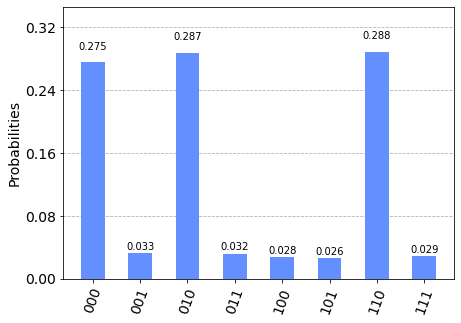

In [7]:
plot_histogram(job.result().get_counts())    

And Et Voila! we can see that the strings corresponding to our patterns occur with higher probability !

## QAE based on Quantum Phase Estimation

Now we move on to do Quantum Amplitude Estimation using QPE, an introduction to QPE can be found here https://learn.qiskit.org/course/ch-algorithms/quantum-phase-estimation.

As we saw in the previous section on grover's algorithm there are some 'good' states we seek (like $\ket{s}$) and others 'bad' states that we don't, and usually any arbitrary state is a n weighted mixture of both kind of this states, as such
$$
    \ket{\psi_0} = \sqrt{a}\ket{good} + \sqrt{1-a}\ket{bad}
$$

 The objective of QAE is to provide a numerical estimate of the coeffcient 'a', this is usually done in two steps, the first step involves amplifying the amplitude corresponding to the $\ket{good}$ states by using the Grover operators described in the last section and in the second step we estimate the amplitude by using the Quantum Phase Estimation algorithm. 


In [8]:
## sub-routines for QPE ~
def crot(qc, l):
    """ Function to generate Controlled Rotation Ooeration  """
    if l == 0:
        return qc
    l = l-1
    qc.h(l)
    for q in range(l):
        qc.cp(pi/2**(l-q), q, l)
    #qc.barrier()
    # qc.draw()
    
def QFT(qc):
   """function to generate QFT circuit """
   dim = qc.num_qubits
   for q in range(dim):
      crot(qc, dim-q)
   for q in range(int(dim/2)):
      qc.swap(q, dim-q-1)

   #qc.draw()
   return qc
   

In [9]:
## modified sub-routine for grover ~
## Based on the 'grover_iterate()' function defined earlier
def grover(patterns, grover_steps):
    
    dim = len(patterns[0])
    
    # create oracles ~\
    oracles = []
    for pattern in patterns : oracles.append( to_oracle(pattern)) 
    
    # create diffuser ~\
    diff = diffuser(dim)

    # create circuit ~\
    qreg = QuantumRegister(dim, name= 'init')
    ancilla = AncillaRegister(1, name='ancilla')
    qc = QuantumCircuit(qreg, ancilla, name='grover'+'^'+str(grover_steps))
    qc = grover_iterate(qc, oracles, diff, qreg, ancilla,grover_steps)
  
    return qc

## 1 Qubit Example  :


Say we have a single qubit state $ \ket{\psi_{0}} = \sqrt{p} \ket{1} + \sqrt{1-p} \ket{0} $ and we are interested in nuemrically estimating the amplitude of $\ket{1}$ i.e 'a'.
We can have, $\sqrt{p} = sin(\theta)$ and $\sqrt{1-p} = cos(\theta)\\$ 
Then the amplitude amplification process requires operator
$\begin{equation}
    \mathcal{Q} = -\mathcal{S}_{\ket{\psi_0}} \mathcal{S}_{\ket{1}}
\end{equation}$
where, $\mathcal{S}_{\ket{\psi_0}} and \mathcal{S}_{\ket{1}}$ are reflection operators about $\ket{\psi_0}$ and $\ket{1}$ respectively $\\$
As, 
$\mathcal{S}_{\ket{\psi_0}} = R_y(\theta)$, and $\mathcal{S}_{\ket{\psi_0}} = \mathbb{I} - \ket{1}\bra{1}$, a simple algebra leads us to 
$\mathcal{Q} = cos(\theta) (\ket{0}\bra{0} + \ket{1}\bra{1}) + sin(\theta) (\ket{0}\bra{1} - \ket{1}\bra{0}) = R_{y}(2\theta) \\ $
 


Note that applying the Grover operator $t$ times is equivalent to
$$  \mathcal{Q}^{t} \ket{\psi_0} = sin((2t+1)\theta)\ket{1} cos((2t+1)\theta)\ket{0}
 
$$ 

Here we define some functions that would implement the state preparation $\ket{\psi_0}$ and grover operator $\textbf{G}$

In [10]:
## operator preparation ~
def s_psi0(p):
    """ Prepare a QuantumCircuit that intiates a state required
        input:
            p= amplitude 
        output:
            s_psi0 gate                                            """
    qc = QuantumCircuit(1, name= " S_psi0 ")
    theta = 2*np.arcsin(np.sqrt(p))
    qc.ry(theta, 0)

    return qc.to_gate()

def Q(p, power):
    """ Prepare an Gate to implement 'Q^power' operator
        input:
            p= amplitude
            power= no.of times 'Q' is imposed
        output:
            Q gate"""
    theta = 2*np.arcsin(np.sqrt(p))
    qc = QuantumCircuit(1, name= ' Q'+ '^'+ str(power) )
    qc.ry(2*theta*power, 0)

    return qc.to_gate()
    

Next let's set the 'p' value of your choice for the state preparation, and also choose the 'precision' of the QPE algorithm to generate the full implementation of the QAE algorithm.

In [11]:
## set p ~
p = 0.85

## set precision ~
precision = 4

## generate the Quantum Circuit ~
preg = QuantumRegister(precision, name= 'precision_q')
qreg = QuantumRegister(1, name='qreg')
creg = ClassicalRegister(precision, name='precision_c')
qc = QuantumCircuit(preg,qreg, creg)

qc.h(preg)
qc.append(s_psi0(p), [precision] )
qc.barrier()
for q in range(precision):
    qc.append(Q(p,2**q).control(1), [q]+list(range(precision,precision+1)) )

qftgate_inv = QFT(QuantumCircuit(precision, name='QFT')).to_gate().inverse()
qc.barrier()
qc.append(qftgate_inv, list(range(precision)))


qc.draw()

┌───┐     ░                                  ░ ┌─────────┐
precision_q_0: ───┤ H ├─────░────■─────────────────────────────░─┤0        ├
                  ├───┤     ░    │                             ░ │         │
precision_q_1: ───┤ H ├─────░────┼───────■─────────────────────░─┤1        ├
                  ├───┤     ░    │       │                     ░ │  QFT_dg │
precision_q_2: ───┤ H ├─────░────┼───────┼───────■─────────────░─┤2        ├
                  ├───┤     ░    │       │       │             ░ │         │
precision_q_3: ───┤ H ├─────░────┼───────┼───────┼───────■─────░─┤3        ├
               ┌──┴───┴───┐ ░ ┌──┴───┐┌──┴───┐┌──┴───┐┌──┴───┐ ░ └─────────┘
         qreg: ┤  S_psi0  ├─░─┤  Q^1 ├┤  Q^2 ├┤  Q^4 ├┤  Q^8 ├─░────────────
               └──────────┘ ░ └──────┘└──────┘└──────┘└──────┘ ░            
precision_c: 4/═════════════════════════════════════════════════════════════

All that is left now is to measure the precision qubits!

In [12]:
qc.measure(preg, creg)
job = execute(qc, backend= aer, shots= 2000)
counts = job.result().get_counts()
# counts

and plot em'

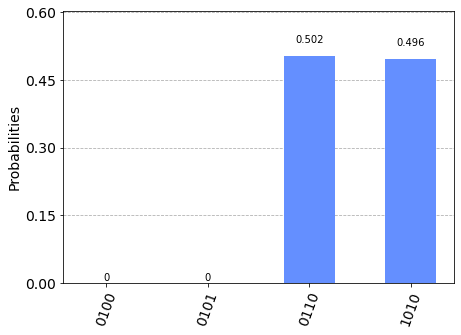

In [13]:
plot_histogram(counts)

We can see that the distributions is symmetric about the $\ket{0001}$ state, this follows from the periodicity of the sine function. Next we calculate 'p' from the best estimates from our measurements


In [14]:
no_estimates= 2
estimate = sorted(zip(counts.values(), counts.keys()), reverse= True)
for p in range(no_estimates): print('p = ',(np.sin(int(estimate[p][1], 2)*pi/(2**precision)))**2 )

p =  0.8535533905932737
p =  0.8535533905932737


We obtain a pretty close approximation of 'p' = 0.853 from the two sgnificant peaks in the histogram. You can try setting up a different 'no_estimates' or 'precision' for a better result !

Next we extend our implementation to multi-qubit case !

## Generalised Multi-Qubit QAE

For the multi qubit case consider a n-qubit system, such that some of its computational basis state are marked 'good' while others are marked 'bad' states as mentioned in the descussion above. 
Then if we start with an equal superposition state, then the initial state can be expressed as 
$\begin{equation}
    \ket{\psi_0} = \sqrt{\frac{M}{N}}\ket{bad} + \sqrt{\frac{N-M}{N}}\ket{good}
\end{equation}$
where $N = 2^n$ is the no. of computational basis states and $M$ is the no. of 'good' states.$\\$
Our aim here is to estimate the number of 'good' states $\frac{M}{N}$ using QPE as proposed by Brassard et al ('96) $\\$
As before we assume,
$\begin{align}
    \sqrt{\frac{M}{N}} = cos(\frac{\theta}{2}) \\
    \sqrt{\frac{N-M}{N}} = sin(\frac{\theta}{2})
\end{align}$ 
and then QPE to estimate the coeffcient of $\ket{good}$ states.



As before we chose set of binary strings as our pattern 

In [15]:
# patterns = [[0,1,1],[0,1,0],[1,1,1],[1,0,1],[1,1,0],[0,0,0],[0,0,1]]
patterns = [[0,1,1,1],[0,0,1,0],[1,0,1,1], [0,0,0,0]]
good_states = [ ''.join([str(elem) for elem in pattern]) for pattern in patterns ]

Since, we are using M= 4 $\ket{good}$ states out of N= 16 possible states, so ideally we should obtain $\frac{3}{16}$ value of 0.25

Here we illustrate how we can use qiskit's 'EstimationProblem' and 'AmplitudeEstimation' module to estimate the amplitude !


In [16]:
## using qiksit Estimation problem module
d = len(patterns[0])
qreg = QuantumRegister(d)
ancilla = AncillaRegister(1)
stateprep = QuantumCircuit(qreg, ancilla)
stateprep.h(qreg)

estimation = EstimationProblem(stateprep, [0,1,2,3], grover_operator= grover(patterns,1), is_good_state= good_states)
precision = 5
ae = AmplitudeEstimation(
    num_eval_qubits=precision,  # the number of evaluation qubits specifies circuit width and accuracy
    quantum_instance= QuantumInstance(stv_simulator) 
)
rslt = ae.estimate(estimation)
# rslt.estimaation, rslt.mle , 7/8

In [17]:
1-rslt.estimation, 1-rslt.mle , len(patterns)/2**(len(patterns[0])) 

(0.2222149, 0.2500000093022525, 0.25)

Next we provide implementation of the above from scratch, the basic steps are the same as before! We set the 'precsion' to our required level, prepare the intial state $\psi_0$ by applying 'H' gates to all qubits and then simply append our QPE steps to it.

In [18]:
## implementation from scratch ~
precision = 5 
preg = QuantumRegister(precision, name='precision_q')
qreg = QuantumRegister(4,name='qreg')
ancilla = AncillaRegister(1, name='ancilla')
creg = ClassicalRegister(precision, name='precison_c')

qc = QuantumCircuit(preg, qreg, ancilla, creg)

qc.h(preg)
qc.h(qreg)
for q in range(precision):
    qc.append(grover(patterns,2**q).to_gate().control(1), [q]+list(range(precision,precision+5)) )

qftgate_inv = QFT(QuantumCircuit(precision, name='QFT')).to_gate().inverse()
qc.barrier()
qc.append(qftgate_inv, list(range(precision)))

qc.decompose(gates_to_decompose= ['grover^1']).draw()


┌───┐                                                    »
precision_q_0: ┤ H ├──────■─────────────────────────────────────────────»
               ├───┤      │                                             »
precision_q_1: ┤ H ├──────┼────────────■────────────────────────────────»
               ├───┤      │            │                                »
precision_q_2: ┤ H ├──────┼────────────┼────────────■───────────────────»
               ├───┤      │            │            │                   »
precision_q_3: ┤ H ├──────┼────────────┼────────────┼────────────■──────»
               ├───┤      │            │            │            │      »
precision_q_4: ┤ H ├──────┼────────────┼────────────┼────────────┼──────»
               ├───┤┌─────┴─────┐┌─────┴─────┐┌─────┴─────┐┌─────┴─────┐»
       qreg_0: ┤ H ├┤0          ├┤0          ├┤0          ├┤0          ├»
               ├───┤│           ││           ││           ││           │»
       qreg_1: ┤ H ├┤1          ├┤1          ├┤1          ├┤1          ├»
               ├───┤│           ││           ││           ││           │»
       qreg_2: ┤ H ├┤2 grover^1 ├┤2 grover^2 ├┤2 grover^4 ├┤2 grover^8 ├»
               ├───┤│           ││           ││           ││           │»
       qreg_3: ┤ H ├┤3          ├┤3          ├┤3          ├┤3          ├»
               └───┘│           ││           ││           ││           │»
      ancilla: ─────┤4          ├┤4          ├┤4          ├┤4          ├»
                    └───────────┘└───────────┘└───────────┘└───────────┘»
 precison_c: 5/═════════════════════════════════════════════════════════»
                                                                        »
«                              ░ ┌─────────┐
«precision_q_0: ───────────────░─┤0        ├
«                              ░ │         │
«precision_q_1: ───────────────░─┤1        ├
«                              ░ │         │
«precision_q_2: ───────────────░─┤2 QFT_dg ├
«                              ░ │         │
«precision_q_3: ───────────────░─┤3        ├
«                              ░ │         │
«precision_q_4: ──────■────────░─┤4        ├
«               ┌─────┴──────┐ ░ └─────────┘
«       qreg_0: ┤0           ├─░────────────
«               │            │ ░            
«       qreg_1: ┤1           ├─░────────────
«               │            │ ░            
«       qreg_2: ┤2 grover^16 ├─░────────────
«               │            │ ░            
«       qreg_3: ┤3           ├─░────────────
«               │            │ ░            
«      ancilla: ┤4           ├─░────────────
«               └────────────┘ ░            
« precison_c: 5/════════════════════════════
«

And measure and plot the outcomes....

In [19]:
qc.measure(preg, creg)
job = execute(qc, backend= aer, shots= 2000)
counts = job.result().get_counts()
# counts

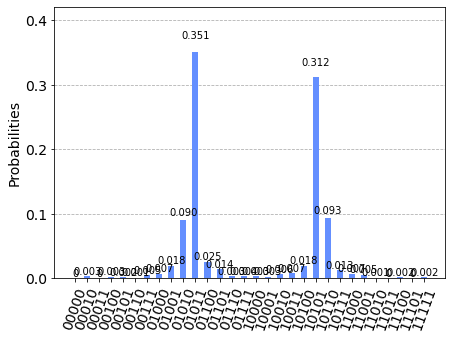

In [20]:
plot_histogram(counts)

.. and estimate the value $\frac{M}{N}$..

In [21]:
estimate = sorted(zip(counts.values(), counts.keys()), reverse= True)
for p in range(4): print('M/N = ',1-(np.sin(int(estimate[p][1], 2)*pi/(2**precision)))**2 )

M/N =  0.22221488349019902
M/N =  0.2222148834901988
M/N =  0.30865828381745475
M/N =  0.3086582838174551


The best estimate is around $M/N \approx 0.22 $ giving $ M \approx 3.5 $, which is pretty close to the actual value of $ M = 4 $! Try tweaking the 'precsion' levels to get a better estimate .

## QAE based on Maximum Likelihood Estimation

In this section we wil elborate a rather different scheme of amplitude estiamtion which does not involve quantum phase estiamtion. This technique was first proposed by Suzuki et al in https://arxiv.org/abs/1904.10246. The main motivation to not use QPE in our estimation algorithm is the incresead circuit depth introduced due to repeated application of the grover operators. Given the contemporary NISQ devices our implementations would accumulate significant amount of errors with increasing depth of the ciruit such that our estimates might become invalid.


To get around this problem we use the follwing scheme. 

We know from our discussion above that for an arbitrary intial state of $\ket{\psi_0} = sin(\theta)\ket{good} + cos(\theta)\ket{bad}$ , applying the grover operator $\mathcal{Q}$ $t$ times leads to,
$$  \mathcal{Q}^t \ket{\psi_0} = sin((2t+1)\theta) \ket{good} + cos((2t+1)\theta) \ket{bad}
$$ 
Now if one measures the state in comptational basis, the probabiility of measuring it in $\ket{good}$ state would be  $\mathtt{P}(\ket{good}) = |sin((2t+1))|^2$ for a single measurement. Thus it follows that if we measure the states 'N' times probability of getting $\ket{good}$ states 'h' times is given by the likelihood function as
$$      \mathtt{P}(N,h,t|\theta) = \big( |sin((2t+1)\theta)|^2  \big)^h \big( |cos((2t+1)\theta)|^2  \big)^{N-h}
$$

Since our onjective here is to get an estimate of $\theta $, we can do a brute force search over some equidistant grid of $\theta$ values such that the likelihood $\mathtt{P}(N,h,t|\theta)$ is maximised. 

As described in the paper by Suzuki et al we can obtain a sequence of likelihood functions by using different possible values of $N$ and $t$ and combine them  
$$  \mathtt{P'} = \Pi_{N_i,t_i, h_i} \mathtt{P}(N_i, t_i, h_i|\theta)
$$ 

and find $\theta$ tha maximises the combined likelihood function.

The data for the estimation problem is obtained by experimentting on the various values of N and t and measuring the corresponding h in form {$(N_1,t_1,h_1), (N_2,t_2,h_2), (N_3,t_3,h_3)$ ... } .

In [53]:
## example circuit

p , q = 0.3, 1    
qreg = QuantumRegister(1, name= 'qreg')
creg = ClassicalRegister(1, name= 'creg')
qc = QuantumCircuit(qreg, creg )

qc.append(s_psi0(p),[0])
qc.barrier()
qc.append(Q(p, q), [0])

qc.measure(qreg, creg)
qc.draw()

┌──────────┐ ░ ┌──────┐┌─┐
  qreg: ┤  S_psi0  ├─░─┤  Q^1 ├┤M├
        └──────────┘ ░ └──────┘└╥┘
creg: 1/════════════════════════╩═
                                0

In [54]:
## example circuit

p , q = 0.3, 2   
qreg = QuantumRegister(1, name= 'qreg')
creg = ClassicalRegister(1, name= 'creg')
qc = QuantumCircuit(qreg, creg )

qc.append(s_psi0(p),[0])
qc.barrier()
qc.append(Q(p, q), [0])

qc.measure(qreg, creg)
qc.draw()

┌──────────┐ ░ ┌──────┐┌─┐
  qreg: ┤  S_psi0  ├─░─┤  Q^2 ├┤M├
        └──────────┘ ░ └──────┘└╥┘
creg: 1/════════════════════════╩═
                                0

In [55]:
## example circuit

p , q = 0.3, 4
qreg = QuantumRegister(1, name= 'qreg')
creg = ClassicalRegister(1, name= 'creg')
qc = QuantumCircuit(qreg, creg )

qc.append(s_psi0(p),[0])
qc.barrier()
qc.append(Q(p, q), [0])

qc.measure(qreg, creg)
qc.draw()

┌──────────┐ ░ ┌──────┐┌─┐
  qreg: ┤  S_psi0  ├─░─┤  Q^4 ├┤M├
        └──────────┘ ░ └──────┘└╥┘
creg: 1/════════════════════════╩═
                                0

However for most practical cases one or two intances of the likelihood function yeilds reasonably accurate estimates !

Now let's see an example of amplitude estimation using maximum liklihood estimation for the simple one qubit case, where we have 
$$ \ket{\psi_0} = \sqrt{a}\ket{1} + \sqrt{1-a}\ket{0}
$$
and our aim as before is to estimate 'a'.

First let's define some helper functions to assist us in this task 

In [50]:
## helper functions for likelihood estimation
def likelihood(n,m, shots, thetas= np.linspace(0, 2*pi, 100), log= False):
    """ Generate likelihood function over the given range of 'thetas'
        Input:
            n = count of 'good' state i.e '1'
            m = no. of grover steps
            shots = no. of shots
            thetas = range of angles 
            log = (Bool) return the log value of likelihood   
        Output:
            dictionary containing {theta: liklihood(theta)} pairs"""
    dic = {}
    for theta in thetas: 
        dic[theta] = (((np.sin((2*m+1)*theta))**2)**n)*(((np.cos((2*m+1)*theta))**2)**(shots-n)) 
        if log== True: dic[theta] = np.log((((np.sin((2*m+1)*theta))**2)**n)*(((np.cos((2*m+1)*theta))**2)**(shots-n)) )
    return dic

def combine_likelihood(lkhs):
    """ Combine a list of liklehoods """
    dic = lkhs[0]
    for lkh in lkhs[1:]: 
        for theta in lkh.keys():
            dic[theta] = dic[theta]*lkh[theta]
            
    return dic

def generate_le(p,q= 1, shots= 100, thetas= np.linspace(0, 2*pi, 50, endpoint= False)):
    """ Generate likelihood for various values of 'p' and 'q' 
        Input:
            p= amplitude
            q= no. of grover steps
        Output:
            dictionary of likelihood
            """
        
    qreg = QuantumRegister(1, name= 'qreg')
    creg = ClassicalRegister(1, name= 'creg')
    qc = QuantumCircuit(qreg, creg )

    qc.append(s_psi0(p),[0])
    qc.barrier()
    qc.append(Q(p, q), [0])

    qc.measure(qreg, creg)
    counts =  execute(qc, backend= aer, shots = shots).result().get_counts()
    le = likelihood(counts['1'],q,shots,thetas= thetas)

    return le
    
    

For example 

Let's know proceed with our example

In [43]:
## set p 
p = 0.23

## set values of q for which observation is required
qs= [1,2,3,4,5,6,7]

## generatte liklihoods for q in qs
les = [ generate_le(p, q= q, shots= 50 ) for q in qs ]

## combine the genrated likelihoods
les_f = combine_likelihood(les)

Here we plot the likelihood function evaluated over the grid of theta values for different values of the grover steps

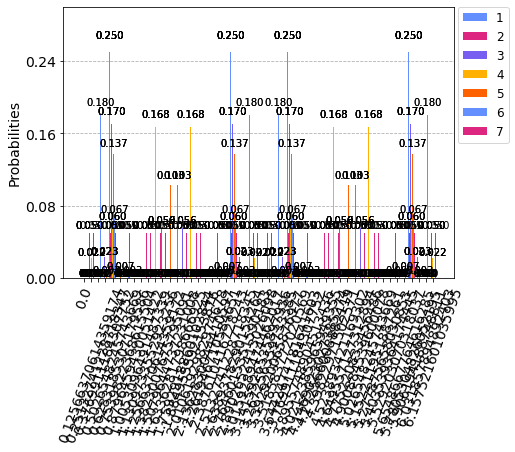

In [44]:
plot_histogram(les, legend = [str(i) for i in qs ])

And also the combined likelihood function 

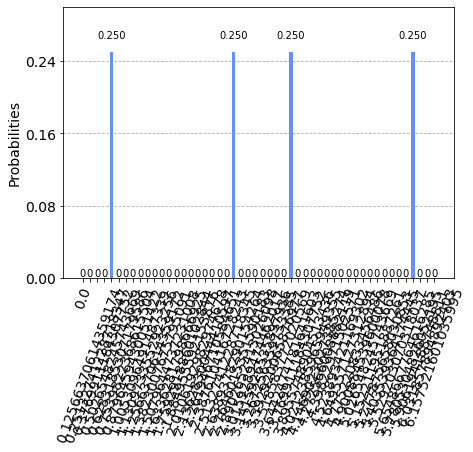

In [45]:
plot_histogram(les_f)

In [48]:
i = 4
estimate = sorted(zip(les[i].values(), les[i].keys()), reverse= True)
for p in range(4): print('theta = ',estimate[p][1] ), print(' p = ', (np.sin(estimate[p][1]))**2 ) 

theta =  2.6389378290154264
 p =  0.23208660251050164
theta =  5.7805304826052195
 p =  0.23208660251050173
theta =  3.6442474781641603
 p =  0.23208660251050178
theta =  0.5026548245743669
 p =  0.23208660251050173


In [49]:
estimate = sorted(zip(les_f.values(), les_f.keys()), reverse= True)
for p in range(5): print('theta = ',estimate[p][1] ), print(' p = ', (np.sin(estimate[p][1]))**2 ) 

theta =  2.6389378290154264
 p =  0.23208660251050164
theta =  3.6442474781641603
 p =  0.23208660251050178
theta =  0.5026548245743669
 p =  0.23208660251050173
theta =  5.7805304826052195
 p =  0.23208660251050173
theta =  0.7539822368615504
 p =  0.4686047402353434
